In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys, pickle
from importlib import reload
from tqdm import tqdm, trange

import numpy as np, pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import agama 
agama.setUnits(mass=1, length=1, velocity=1) #Msol, kpc, km/s. Time is in kpc/(kms/s)
# agama.setNumThreads(48)  

# sys.path.insert(1, '/mnt/d/Research/')
# import compute_characteristics_ut as cc

sys.path.append('../scripts/')
import stream_sim_funcs as ssf

import emcee
import corner

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential, CartesianRepresentation
from astropy import table

from aau_likelihood import log_likelihood, make_spline, log_prior, log_probability

In [2]:
# Define file paths
BASE_POT_PATH = '../scripts/'
potMW_path = os.path.join(BASE_POT_PATH, 'McMillan17_nora.ini')
potLMC_path = os.path.join(BASE_POT_PATH, 'LMC_nora.ini')
accMW_path = os.path.join(BASE_POT_PATH, 'accMW')
trajLMC_path = os.path.join(BASE_POT_PATH, 'trajLMC')

## potential models to load
potMW = agama.Potential(file=potMW_path)
accMW = np.loadtxt(accMW_path)
trajLMC = np.loadtxt(trajLMC_path)
potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
potLMC  = agama.Potential(file=potLMC_path)
potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
potTotal= agama.Potential(potMW, potLMCm, potacc)

In [3]:
#Reading in all our data
member_path = '../data/aau_members.csv'
distance_path = '../data/aau_bhb_rrl.csv'

s5_table = pd.read_csv(member_path)
bhb_rrl_data = pd.read_csv(distance_path)

def select_median_array(data_file, distance_file):
    
    '''
    Function takes in two tables -- one large data table, and one distance table.
    '''
    
    df = data_file
    df_distance = distance_file

    select_phi1 = (df['phi1'] > -5.7) & (df['phi1'] < -5.4)

    coefficients = np.polyfit(distance_file['Phi1'], distance_file['Distance_Modulus'], deg=2)
    
    distance_fit = np.poly1d(coefficients)
    dist_kpc_data = (10 ** ((distance_fit(df['phi1']))/5 +1))*1e-3

    phi1med = np.median(df.loc[select_phi1,'phi1'])
    phi2med = np.median(df.loc[select_phi1,'phi2'])
    distmed = np.median(dist_kpc_data)
    ramed = np.median(df.loc[select_phi1,'ra'])
    decmed = np.median(df.loc[select_phi1,'dec'])
    pmramed = np.median(df.loc[select_phi1, 'pmra'])
    pmdecmed = np.median(df.loc[select_phi1, 'pmdec'])
    rvmed = np.median(df.loc[select_phi1, 'vel_calib'])

    prog_pars = [float(ramed), float(decmed), float(distmed), float(pmramed), float(pmdecmed), float(rvmed)]

    return df, df_distance, dist_kpc_data, prog_pars

df, df_distance, dist_kpc_data, prog_pars = select_median_array(s5_table, bhb_rrl_data)

data_dict = dict(
    phi1_obs = df['phi1'].values,
    phi2_obs = df['phi2'].values,
    rv_obs = df['vel_calib'].values,
    rv_obs_errors = df['vel_calib_std'].values,
    dist_obs = dist_kpc_data,
    dist_obs_errors = (dist_kpc_data*0.1),
    pmra_cosdec_obs = df['pmra'].values,
    pmra_cosdec_obs_errors = df['pmra_error'].values,
    pmdec_obs = df['pmdec'].values,
    pmdec_obs_errors = df['pmdec_error'].values,
)

In [4]:
#coordinate transform (useful for plotting)
def icrs_to_aau(ra_deg, dec_deg):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> AAU phi1, phi2
    Using the rotation matrix from Shipp+2019
    ra_deg: icrs deg [degrees]
    dec_deg: icrs deg [degrees]
    """
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    
    R = np.array(
        [
            [0.83697865, 0.29481904, -0.4610298],
            [0.51616778,-0.70514011, 0.4861566],
            [0.18176238, 0.64487142, 0.74236331],
        ]
    )

    icrs_vec = np.vstack(
        [
            np.cos(ra_rad) * np.cos(dec_rad),
            np.sin(ra_rad) * np.cos(dec_rad),
            np.sin(dec_rad),
        ]
    ).T

    stream_frame_vec = np.einsum("ij,kj->ki", R, icrs_vec)

    phi1 = np.arctan2(stream_frame_vec[:, 1], stream_frame_vec[:, 0]) * 180 / np.pi
    phi2 = np.arcsin(stream_frame_vec[:, 2]) * 180 / np.pi

    return phi1, phi2

In [5]:
#MCMC fit
nwalkers = 48
niter = 1000

#Taking a fraction of the prior range 
initial = prog_pars
ndim = len(initial)
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

data = (data_dict, potTotal)

def main(p0,nwalkers,niter,ndim,log_probability,data, nburnin=100):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, nburnin, progress = True)
    print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}") #tells us how much of the burn-ins were accepted; 0.2-0.5 good
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress = True)

    return sampler, pos, prob, state

In [6]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability, data)

Running burn-in...


100%|██████████| 100/100 [05:14<00:00,  3.15s/it]


Mean acceptance fraction: 0.399
Running production...


100%|██████████| 1000/1000 [53:13<00:00,  3.19s/it]


In [7]:
#pulling out the values generated by the MCMC sampler XD
samples = sampler.flatchain
prog_pars_max  = samples[np.argmax(sampler.flatlnprobability)]
print(prog_pars_max)

ra_best, dec_best, dist_best, pmra_best, pmdec_best, rv_best = prog_pars_max

aau_c_best = coord.SkyCoord(
    ra=ra_best*u.degree, dec=dec_best*u.degree, distance=dist_best*u.kpc, 
    pm_ra_cosdec=pmra_best*u.mas/u.yr,
    pm_dec=pmdec_best*u.mas/u.yr,
    radial_velocity=rv_best*u.km/u.s
)

rep_best = aau_c_best.transform_to(coord.Galactocentric) # units here are kpc, km/s

prog_best_gal = np.array(
    [rep_best.x.value, rep_best.y.value, rep_best.z.value,
     rep_best.v_x.value, rep_best.v_y.value, rep_best.v_z.value]
) # units here are kpc, km/s

[  21.21458831  -27.57914456   24.05421747   -0.11970963   -0.85301479
 -104.39082968]


In [8]:
# # stream progenitor profile parameters
prog_mass, prog_scaleradius =  20_000, 10/1_000 # Msun, kpc
Age_stream_inGyr = 4.0 # Gyr --<

# # num_particles for the spray model: 
num_particles = 2_000 # # preferably a multiple of 2, leading+trailing arm

#generate the stream with best_fit_params
gen_best_stream = ssf.create_stream_particle_spray(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    prog_pot_kind='Plummer', 
    sat_cen_present=prog_best_gal, 
    num_particles=num_particles,
    time_end=0.0, 
    time_total=Age_stream_inGyr, save_rate=1,
    #add_perturber={'mass':0},
)

#Cleaning up our coordinate frames *whistles nonchalantly*
best_stream_model = gen_best_stream['part_xv']

galcen_best_stream = coord.Galactocentric(
        x=best_stream_model[:,0] * u.kpc,
        y=best_stream_model[:,1] * u.kpc,
        z=best_stream_model[:,2] * u.kpc,
        v_x=best_stream_model[:,3] * u.km/u.s,
        v_y=best_stream_model[:,4] * u.km/u.s,
        v_z=best_stream_model[:,5] * u.km/u.s,
        representation_type='cartesian',
        differential_type='cartesian'
    )

icrs_best_stream = galcen_best_stream.transform_to(coord.ICRS())

ra_max = icrs_best_stream.ra.value
dec_max = icrs_best_stream.dec.value
dist_max = icrs_best_stream.distance.value
pmra_max = icrs_best_stream.pm_ra_cosdec.value
pmdec_max = icrs_best_stream.pm_dec.value
rv_max = icrs_best_stream.radial_velocity.value

phi1_max, phi2_max = icrs_to_aau(ra_max, dec_max)

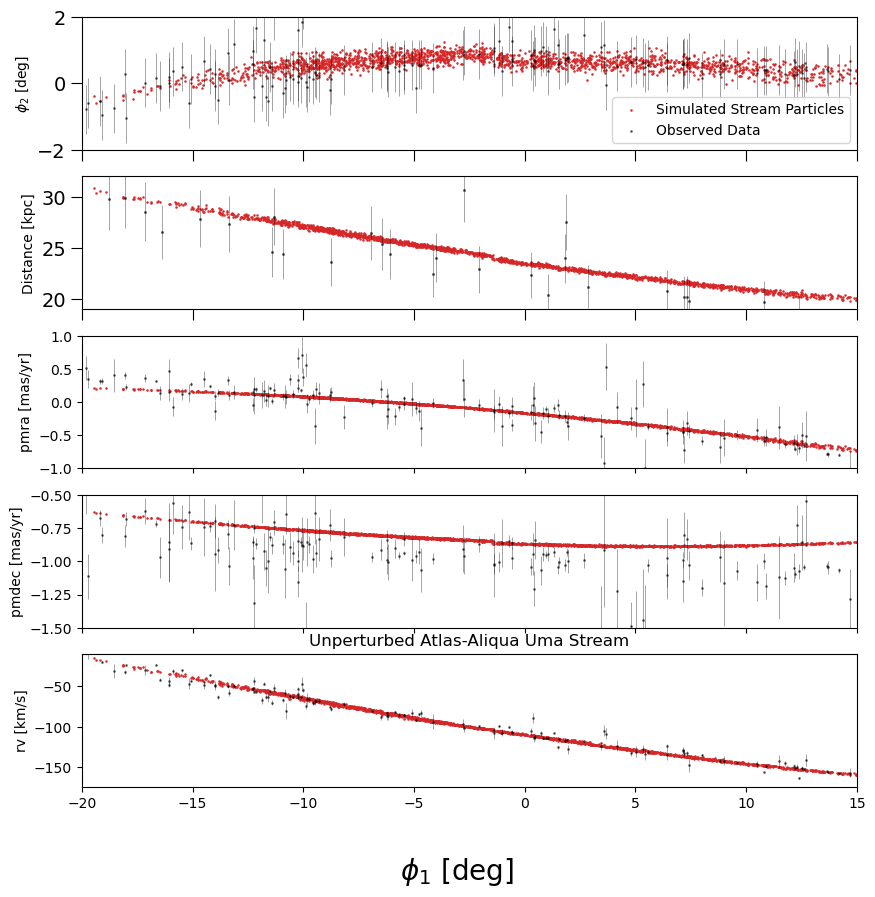

In [15]:
#plot with best-fit progenitor IC's from MCMC!

fig, ax = plt.subplots(5,1, sharex = True)
fig.set_size_inches(10,10)
fig.supxlabel(r'$\phi_1$ [deg]',fontsize=20)
ax[-1].set_xlim(-20,15)
ax[-1].set_title(label ='Unperturbed Atlas-Aliqua Uma Stream',loc='center' )
#simulation
ax[0].scatter(phi1_max, phi2_max,s=0.75,color='tab:red', alpha= 0.9, label = 'Simulated Stream Particles')
ax[0].tick_params(axis='both', which='major', labelsize=14., length=8)
ax[0].tick_params(axis='both', which='minor', length=3)
ax[0].set_ylim(-2,2)

ax[0].set_ylabel(r'$\phi_2$ [deg]', fontsize=10)
ax[1].scatter(phi1_max, dist_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[1].tick_params(axis='both', which='major', labelsize=14., length=8)
ax[1].tick_params(axis='both', which='minor', length=3)
ax[1].set_ylabel('Distance [kpc]', fontsize=10)
ax[1].set_ylim(19,32)

ax[2].scatter(phi1_max, pmra_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[2].set_ylim(-1,1)
ax[2].set_ylabel('pmra [mas/yr]', fontsize=10)

ax[3].scatter(phi1_max, pmdec_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[3].set_ylabel('pmdec [mas/yr]', fontsize=10)
ax[3].set_ylim(-1.5,-0.5)

ax[4].scatter(phi1_max, rv_max,s=0.75,color='tab:red',alpha= 0.9)
ax[4].set_ylabel('rv [km/s]', fontsize=10)
ax[4].set_ylim(-175,-10)

#data
ax[0].scatter(df['phi1'], df['phi2'] , s=1,color='k', alpha = 0.5, label = 'Observed Data')
ax[0].errorbar(df['phi1'], df['phi2'], yerr=np.nanstd(df['phi2']), fmt='none', ecolor='k', alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[1].scatter(df_distance['Phi1'],(10**((df_distance['Distance_Modulus'])/5 +1)*1e-3),s=1.5,color='k', alpha = 0.5)
ax[1].errorbar(df_distance['Phi1'],(10**((df_distance['Distance_Modulus'])/5 +1)*1e-3), yerr=np.abs(((10**((df_distance['Distance_Modulus'])/5 +1)*1e-3))*0.1), fmt='none', ecolor='k',alpha = 0.5,capsize=0, capthick=0.7, elinewidth=0.5)


ax[2].scatter(df['phi1'], df['pmra'],s=1,color='k', alpha = 0.5)
ax[2].errorbar(df['phi1'], df['pmra'], yerr=df['pmra_error'], fmt='none', ecolor='k',alpha = 0.5,capsize=0, capthick=0.7, elinewidth=0.5)

ax[3].scatter(df['phi1'], df['pmdec'],s=1,color='k',alpha = 0.5)
ax[3].errorbar(df['phi1'], df['pmdec'], yerr=df['pmdec_error'], fmt='none', ecolor='k', alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[4].scatter(df['phi1'], df['vel_calib'],s=1,color='k', alpha = 0.5)
ax[4].errorbar(df['phi1'], df['vel_calib'], yerr=df['vel_calib_std'], fmt='none', ecolor='k',alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[0].legend(loc = 'lower right')
fig.savefig('../notebooks/new_evo_pot_mcmc.pdf')

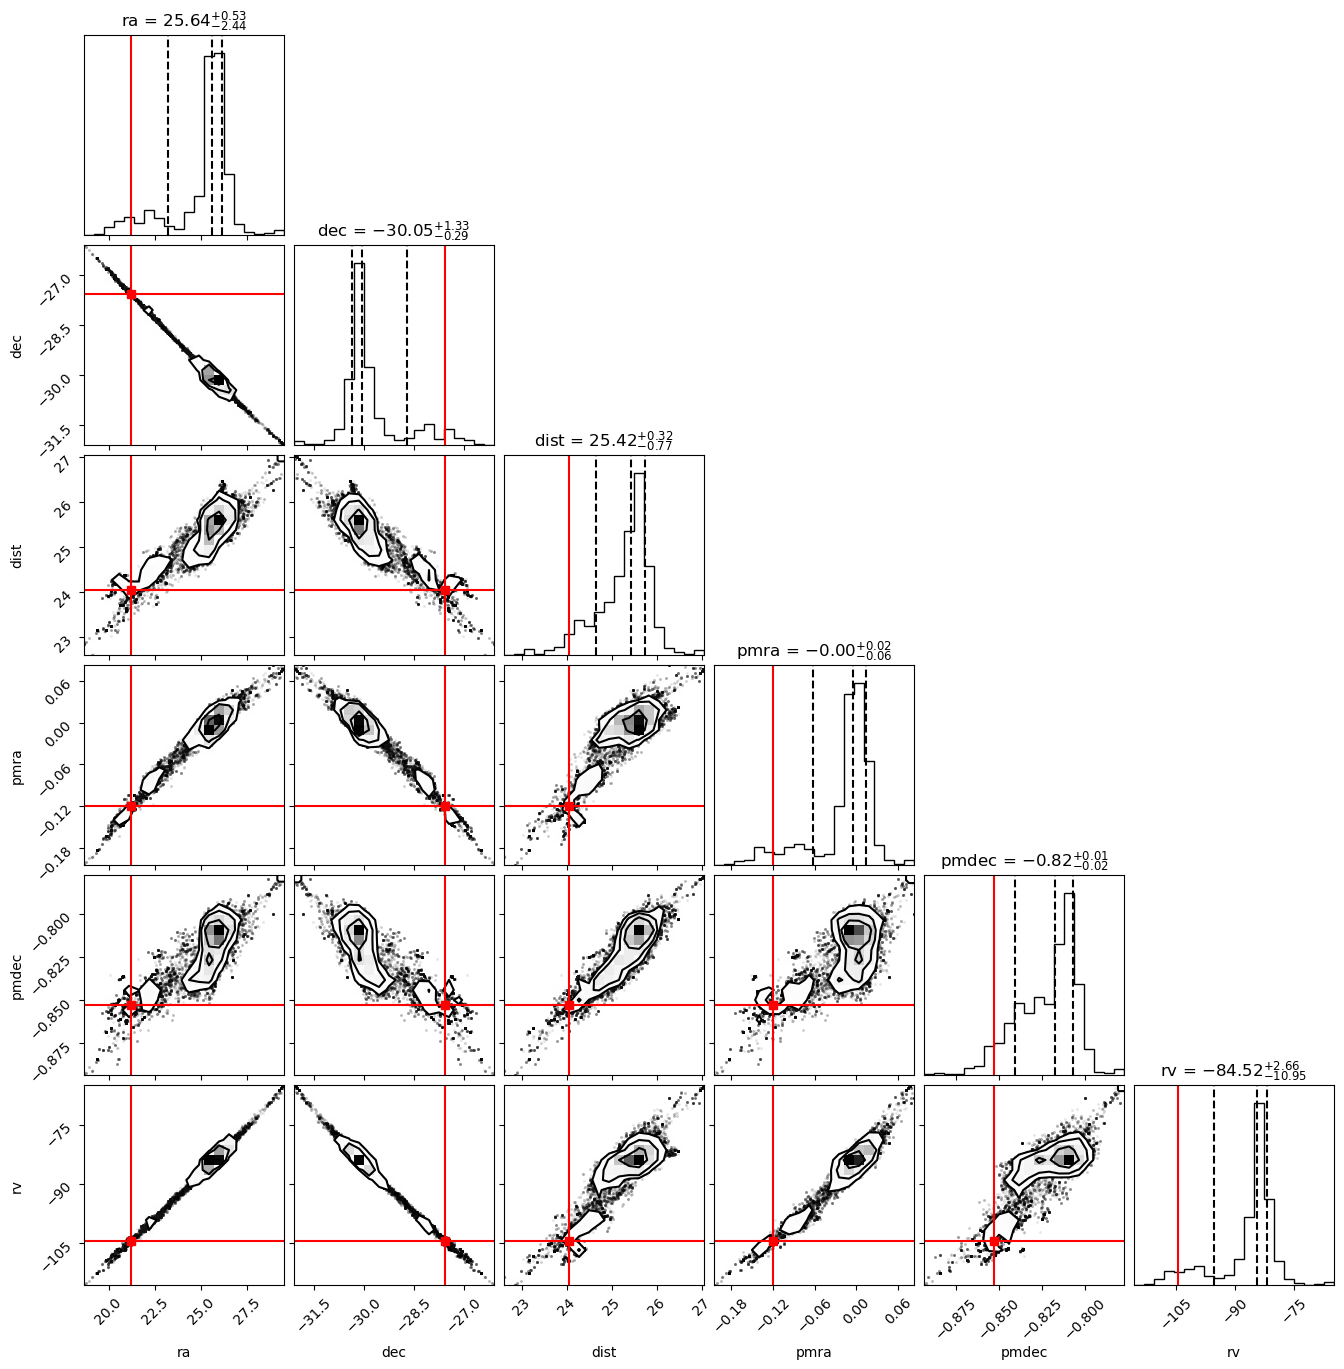

In [14]:
#MCMC checks!
labels = ['ra', 'dec', 'dist', 'pmra', 'pmdec', 'rv']

fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=prog_pars_max,  # Show best fit
    truth_color='red', fig_kwargs={'figsize': (6, 6)}
)
fig.savefig('../notebooks/new_cornerplot.pdf')
plt.show()